In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
df_gcta = pd.read_csv(
    "/data/jerrylee/pjt/BIGFAM.v.2.0/data/other-methods/GREML/X/X.all.gcta",
    sep = '\t'
)

df_gcta

,pheno,n_meta,sex,X_GCTA,se_X_GCTA
0,Nucleated_red_blood_cell_percentage,30,all,0.002071,0.001090
1,Nucleated_red_blood_cell_percentage,30,female,0.004284,0.001995
2,Nucleated_red_blood_cell_percentage,30,male,0.004651,0.002401
3,"Hair_colour__natural,_before_greying_",30,all,0.004818,0.001090
4,"Hair_colour__natural,_before_greying_",30,female,0.008090,0.002017
...,...,...,...,...,...
385,Neuroticism_score,30,female,0.006252,0.002461
386,Neuroticism_score,30,male,0.005406,0.002814
387,Alanine_aminotransferase,30,all,0.002509,0.001097
388,Alanine_aminotransferase,30,female,0.005056,0.002023


In [3]:
path = f"/data/jerrylee/pjt/BIGFAM.v.2.0/data/UKB/obj2/prediction-X/X.tsv"
df_bigfam_all = pd.read_csv(path, sep = '\t')

path = "/data/jerrylee/pjt/BIGFAM.v.2.0/data/UKB/obj2/prediction-XmXf/XmXf.tsv"
df_bigfam_mf = pd.read_csv(path, sep = '\t')

# X

In [26]:
# formatting GCTA
df_gcta_x = (df_gcta.loc[df_gcta["sex"] == "all"]
             .reset_index(drop = True))
df_gcta_x["GCTA"] = df_gcta_x["X_GCTA"]
df_gcta_x["lower_GCTA"] = df_gcta_x["GCTA"] - 1.96 * df_gcta_x["se_X_GCTA"]
df_gcta_x["upper_GCTA"] = df_gcta_x["GCTA"] + 1.96 * df_gcta_x["se_X_GCTA"]

df_gcta_x = df_gcta_x[["pheno", "GCTA", "lower_GCTA", "upper_GCTA"]] 
df_gcta_x = df_gcta_x[df_gcta_x["lower_GCTA"] > 1e-4].reset_index(drop = True)
df_gcta_x.head()

,pheno,GCTA,lower_GCTA,upper_GCTA
0,"Hair_colour__natural,_before_greying_",0.004818,0.002681,0.006954
1,Urate,0.003119,0.000943,0.005295
2,Standing_height,0.020603,0.017991,0.023214
3,IGF-1,0.007575,0.005215,0.009935
4,Monocyte_count,0.002645,0.000494,0.004796


In [27]:
# filter BIGFAM
df_bigfam_x = (df_bigfam_all[df_bigfam_all["lower_Vx"] > 1e-4]
               .reset_index(drop = True))
df_bigfam_x = df_bigfam_x.rename(columns = {
    "Vx": "BIGFAM",
    "lower_Vx": "lower_BIGFAM",
    "upper_Vx": "upper_BIGFAM"
    })
df_bigfam_x = (df_bigfam_x
               .drop(columns = "lambda")
               .reset_index(drop = True))
df_bigfam_x.head()

,pheno,weight,BIGFAM,lower_BIGFAM,upper_BIGFAM
0,Weight,-2,0.061390,0.018048,0.102625
1,Weight,-1,0.051087,0.025228,0.093524
2,Weight,0,0.034649,0.011180,0.064845
3,Weight,1,0.025078,0.007549,0.046254
4,Weight,2,0.016741,0.003218,0.031523


In [28]:
df_mrg_x = pd.merge(df_gcta_x, df_bigfam_x, on = "pheno")
df_mrg_x.head()


,pheno,GCTA,lower_GCTA,upper_GCTA,weight,BIGFAM,lower_BIGFAM,upper_BIGFAM
0,Monocyte_count,0.002645,0.000494,0.004796,-1,0.037934,0.006441,0.071609
1,Monocyte_count,0.002645,0.000494,0.004796,0,0.026667,0.002214,0.049583
2,Monocyte_count,0.002645,0.000494,0.004796,1,0.014550,0.002470,0.028785
3,Monocyte_count,0.002645,0.000494,0.004796,2,0.007828,0.000562,0.013687
4,Monocyte_count,0.002645,0.000494,0.004796,3,0.003659,0.000251,0.007192


In [35]:
def bootstrap_correlation_ci(x, y, n_bootstrap=1000, confidence=0.95):
    n = len(x)
    correlations = []
    
    for _ in range(n_bootstrap):
        # Bootstrap sampling with replacement
        indices = np.random.randint(0, n, size=n)
        x_sample = x.iloc[indices]
        y_sample = y.iloc[indices]
        
        corr = x_sample.corr(y_sample)
        correlations.append(corr)
    
    # Calculate CI from bootstrap distribution
    ci_lower = np.percentile(correlations, (1-confidence)*100/2)
    ci_upper = np.percentile(correlations, (1+confidence)*100/2)
    
    return np.mean(correlations), ci_lower, ci_upper

# weight 값들의 unique 리스트 구하기
weights = df_mrg_x['weight'].unique()

# 각 weight 별로 correlation과 bootstrap CI 계산
correlations = []
for w in weights:
    subset = df_mrg_x[df_mrg_x['weight'] == w]
    corr, ci_lower, ci_upper = bootstrap_correlation_ci(subset['BIGFAM'], subset['GCTA'])
    
    correlations.append({
        'weight': w,
        'correlation': corr,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'n_samples': len(subset)
    })

# 결과를 DataFrame으로 변환
result_df = pd.DataFrame(correlations)
result_df = result_df.sort_values('weight')

result_df

,weight,correlation,ci_lower,ci_upper,n_samples
6,-2,-0.670668,-0.837226,-0.437951,24
0,-1,-0.489771,-0.734933,-0.152042,21
1,0,-0.089890,-0.401136,0.329069,26
2,1,0.505930,0.163731,0.818220,26
3,2,0.659584,0.331700,0.930741,21
4,3,0.623317,0.280095,0.921698,25
7,4,0.412703,-0.191824,0.794152,18
5,5,0.673461,0.374317,0.939407,15
8,6,0.657410,0.236778,0.956129,14
9,7,0.724134,0.282475,0.933233,14


Correlations between BIGFAM and GCTA by weight:
    weight  correlation  ci_lower  ci_upper  n_samples
6       -2    -0.670668 -0.837226 -0.437951         24
0       -1    -0.489771 -0.734933 -0.152042         21
1        0    -0.089890 -0.401136  0.329069         26
2        1     0.505930  0.163731  0.818220         26
3        2     0.659584  0.331700  0.930741         21
4        3     0.623317  0.280095  0.921698         25
7        4     0.412703 -0.191824  0.794152         18
5        5     0.673461  0.374317  0.939407         15
8        6     0.657410  0.236778  0.956129         14
9        7     0.724134  0.282475  0.933233         14
10       8     0.742510  0.394495  0.959565         10


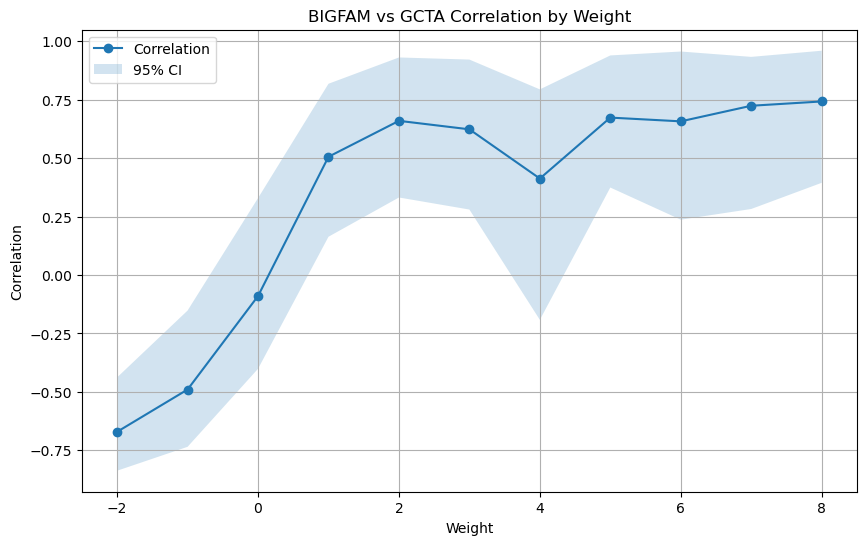

In [36]:
# 결과 출력
print("Correlations between BIGFAM and GCTA by weight:")
print(result_df)

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(result_df['weight'], result_df['correlation'], 'o-', label='Correlation')
plt.fill_between(result_df['weight'], 
                 result_df['ci_lower'], 
                 result_df['ci_upper'], 
                 alpha=0.2, 
                 label='95% CI')

plt.xlabel('Weight')
plt.ylabel('Correlation')
plt.title('BIGFAM vs GCTA Correlation by Weight')
plt.grid(True)
plt.legend()
plt.show()

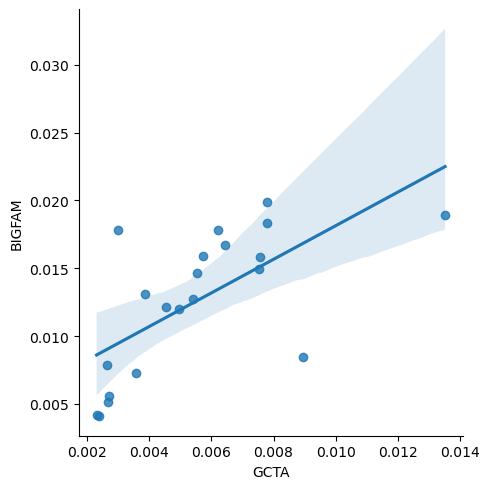

In [42]:
sns.lmplot(
    data = df_mrg_x[df_mrg_x["weight"] == 2],
    x = "GCTA",
    y = "BIGFAM",
    ci = 95,
    n_boot = 1000,
    scatter = True
)

In [59]:
tt = df_mrg_x[df_mrg_x["weight"] == 2]
tt["BIGFAM"] / tt["GCTA"]

3      2.959602
10     5.965658
21     1.977482
32     2.056840
38     2.660390
47     2.089643
56     1.707643
62     1.401339
75     2.353047
87     2.600611
98     2.352109
110    1.803974
116    3.390353
124    2.027783
130    2.421946
140    2.551996
158    2.770300
177    2.640886
187    1.897380
197    0.946638
208    2.859804
dtype: float64

In [61]:
tt.to_csv(
    "/data/jerrylee/pjt/BIGFAM.v.2.0/data/supple/UKB.X.bigfam-gcta.weight2tsv",
    sep = '\t',
    index = False
)

# XmXf

In [4]:
# formatting GCTA
df_gcta_xmxf = (df_gcta.loc[df_gcta["sex"] != "all"]
             .reset_index(drop = True))

# 성별에 따라 GCTA 값과 신뢰구간 계산
df_gcta_xmxf_male = df_gcta_xmxf[df_gcta_xmxf["sex"] == "male"].copy()
df_gcta_xmxf_female = df_gcta_xmxf[df_gcta_xmxf["sex"] == "female"].copy()

# male, female 각각의 GCTA 값과 신뢰구간 계산
df_gcta_xmxf_male["GCTA_male"] = df_gcta_xmxf_male["X_GCTA"]
df_gcta_xmxf_male["lower_GCTA_male"] = df_gcta_xmxf_male["X_GCTA"] - 1.96 * df_gcta_xmxf_male["se_X_GCTA"]
df_gcta_xmxf_male["upper_GCTA_male"] = df_gcta_xmxf_male["X_GCTA"] + 1.96 * df_gcta_xmxf_male["se_X_GCTA"]

df_gcta_xmxf_female["GCTA_female"] = df_gcta_xmxf_female["X_GCTA"] 
df_gcta_xmxf_female["lower_GCTA_female"] = df_gcta_xmxf_female["X_GCTA"] - 1.96 * df_gcta_xmxf_female["se_X_GCTA"]
df_gcta_xmxf_female["upper_GCTA_female"] = df_gcta_xmxf_female["X_GCTA"] + 1.96 * df_gcta_xmxf_female["se_X_GCTA"]

# 필요한 컬럼만 선택하고 병합
df_gcta_xmxf_male = df_gcta_xmxf_male[["pheno", "GCTA_male", "lower_GCTA_male", "upper_GCTA_male"]]
df_gcta_xmxf_female = df_gcta_xmxf_female[["pheno", "GCTA_female", "lower_GCTA_female", "upper_GCTA_female"]]

# male과 female 데이터 병합
df_gcta_xmxf = pd.merge(df_gcta_xmxf_male, df_gcta_xmxf_female, on="pheno")

# 신뢰구간이 너무 작은 값 필터링
df_gcta_xmxf = df_gcta_xmxf[
    (df_gcta_xmxf["lower_GCTA_male"] > 1e-4) & 
    (df_gcta_xmxf["lower_GCTA_female"] > 1e-4)
].reset_index(drop=True)

df_gcta_xmxf.head()

,pheno,GCTA_male,lower_GCTA_male,upper_GCTA_male,GCTA_female,lower_GCTA_female,upper_GCTA_female
0,Standing_height,0.021796,0.016847,0.026745,0.015764,0.011634,0.019895
1,IGF-1,0.010657,0.005788,0.015527,0.004999,0.000991,0.009008
2,Monocyte_count,0.005917,0.001202,0.010632,0.004222,0.000280,0.008165
3,Mean_sphered_cell_volume,0.007942,0.003162,0.012722,0.004587,0.000652,0.008521
4,Leg_predicted_mass__left_,0.013430,0.008641,0.018219,0.006692,0.002717,0.010668


In [5]:
df_bigfam_mf

,pheno,lambda,weight,Vx_male,lower_male_Vx,upper_male_Vx,Vx_female,lower_female_Vx,upper_female_Vx,r,lower_r,upper_r
0,Weight,0.587543,-2,0.070600,0.025355,0.112137,0.019996,0.000522,0.054146,1.0,-1.00,1.0
1,Weight,0.587543,-1,0.048882,0.010641,0.091033,0.018165,0.001074,0.032453,1.0,-1.00,1.0
2,Weight,0.587543,0,0.034032,0.010039,0.061862,0.011808,0.000199,0.022500,1.0,-1.00,1.0
3,Weight,0.587543,1,0.024778,0.008205,0.037224,0.007605,0.000710,0.015694,1.0,-0.05,1.0
4,Weight,0.587543,2,0.014384,0.005886,0.026014,0.004657,0.000798,0.009535,1.0,-1.00,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1161,Triglycerides,0.351913,4,0.000007,0.000001,0.000403,0.000212,0.000050,0.000393,0.6,-1.00,1.0
1162,Triglycerides,0.351913,5,0.000001,0.000001,0.000164,0.000078,0.000019,0.000171,0.4,-1.00,1.0
1163,Triglycerides,0.351913,6,0.000001,0.000001,0.000057,0.000028,0.000005,0.000046,1.0,-1.00,1.0
1164,Triglycerides,0.351913,7,0.000001,0.000001,0.000014,0.000011,0.000003,0.000020,1.0,-1.00,1.0


In [6]:
# filter BIGFAM
df_bigfam_xmxf = (df_bigfam_mf[
    (df_bigfam_mf["lower_male_Vx"] > 1e-4) & 
    (df_bigfam_mf["lower_female_Vx"] > 1e-4)
    ]
    .reset_index(drop = True)
)
df_bigfam_xmxf = df_bigfam_xmxf.rename(columns = {
    "Vx_male": "BIGFAM_male",
    "Vx_female": "BIGFAM_female",
    "lower_male_Vx": "lower_BIGFAM_male",
    "upper_male_Vx": "upper_BIGFAM_male",
    "lower_female_Vx": "lower_BIGFAM_female",
    "upper_female_Vx": "upper_BIGFAM_female"
})

df_bigfam_xmxf = (df_bigfam_xmxf
               .drop(columns = "lambda")
               .reset_index(drop = True))
df_bigfam_xmxf.head()

,pheno,weight,BIGFAM_male,lower_BIGFAM_male,upper_BIGFAM_male,BIGFAM_female,lower_BIGFAM_female,upper_BIGFAM_female,r,lower_r,upper_r
0,Weight,-2,0.070600,0.025355,0.112137,0.019996,0.000522,0.054146,1.0,-1.00,1.0
1,Weight,-1,0.048882,0.010641,0.091033,0.018165,0.001074,0.032453,1.0,-1.00,1.0
2,Weight,0,0.034032,0.010039,0.061862,0.011808,0.000199,0.022500,1.0,-1.00,1.0
3,Weight,1,0.024778,0.008205,0.037224,0.007605,0.000710,0.015694,1.0,-0.05,1.0
4,Weight,2,0.014384,0.005886,0.026014,0.004657,0.000798,0.009535,1.0,-1.00,1.0


In [7]:
df_mrg_xmxf = pd.merge(df_gcta_xmxf, df_bigfam_xmxf, on = "pheno")
df_mrg_xmxf.head()


,pheno,GCTA_male,lower_GCTA_male,upper_GCTA_male,GCTA_female,lower_GCTA_female,upper_GCTA_female,weight,BIGFAM_male,lower_BIGFAM_male,upper_BIGFAM_male,BIGFAM_female,lower_BIGFAM_female,upper_BIGFAM_female,r,lower_r,upper_r
0,Standing_height,0.021796,0.016847,0.026745,0.015764,0.011634,0.019895,1,0.019415,0.000152,0.038989,0.008858,0.000115,0.019784,1.0,-1.0,1.0
1,Standing_height,0.021796,0.016847,0.026745,0.015764,0.011634,0.019895,3,0.019125,0.001154,0.043122,0.007133,0.000128,0.023911,1.0,-1.0,1.0
2,Standing_height,0.021796,0.016847,0.026745,0.015764,0.011634,0.019895,4,0.022856,0.000196,0.043118,0.009143,0.000109,0.020043,1.0,-1.0,1.0
3,Standing_height,0.021796,0.016847,0.026745,0.015764,0.011634,0.019895,6,0.020690,0.000573,0.056854,0.010184,0.000241,0.027437,1.0,-1.0,1.0
4,Standing_height,0.021796,0.016847,0.026745,0.015764,0.011634,0.019895,8,0.027115,0.000618,0.053512,0.011103,0.000343,0.030004,1.0,-1.0,1.0


In [49]:
def bootstrap_correlation_ci(x, y, n_bootstrap=1000, confidence=0.95):
    n = len(x)
    correlations = []
    
    for _ in range(n_bootstrap):
        # Bootstrap sampling with replacement
        indices = np.random.randint(0, n, size=n)
        x_sample = x.iloc[indices]
        y_sample = y.iloc[indices]
        
        corr = x_sample.corr(y_sample)
        correlations.append(corr)
    
    # Calculate CI from bootstrap distribution
    ci_lower = np.percentile(correlations, (1-confidence)*100/2)
    ci_upper = np.percentile(correlations, (1+confidence)*100/2)
    
    return np.mean(correlations), ci_lower, ci_upper

# weight 값들의 unique 리스트 구하기
weights = df_mrg_xmxf['weight'].unique()

# 각 weight 별로 male, female correlation과 bootstrap CI 계산
correlations = []
for w in weights:
    subset = df_mrg_xmxf[df_mrg_xmxf['weight'] == w]
    
    # Male correlation
    corr_male, ci_lower_male, ci_upper_male = bootstrap_correlation_ci(
        subset['BIGFAM_male'], subset['GCTA_male'])
    
    # Female correlation
    corr_female, ci_lower_female, ci_upper_female = bootstrap_correlation_ci(
        subset['BIGFAM_female'], subset['GCTA_female'])
    
    correlations.append({
        'weight': w,
        'correlation_male': corr_male,
        'ci_lower_male': ci_lower_male,
        'ci_upper_male': ci_upper_male,
        'correlation_female': corr_female,
        'ci_lower_female': ci_lower_female,
        'ci_upper_female': ci_upper_female,
        'n_samples': len(subset)
    })

# 결과를 DataFrame으로 변환
result_df = pd.DataFrame(correlations)
result_df = result_df.sort_values('weight')

result_df

,weight,correlation_male,ci_lower_male,ci_upper_male,correlation_female,ci_lower_female,ci_upper_female,n_samples
5,-2,0.004540,-0.369792,0.417896,-0.085089,-0.318652,0.238017,30
6,-1,0.087383,-0.341118,0.498142,-0.111547,-0.357825,0.240781,28
7,0,0.017592,-0.413923,0.478014,0.126921,-0.328980,0.477313,27
0,1,0.302933,-0.110192,0.671387,0.217422,-0.143659,0.601769,24
8,2,0.624764,0.269914,0.833694,0.759467,0.468483,0.944420,16
1,3,0.788951,0.477275,0.956432,0.892083,0.738507,0.973715,16
2,4,0.793648,0.416141,0.963414,0.872476,0.616609,0.988918,15
9,5,0.600281,0.223568,0.869241,0.778534,0.283520,0.964093,13
3,6,0.783897,0.372796,0.954924,0.818889,0.379938,0.982660,14
10,7,0.518881,-0.019389,0.857773,0.624475,-0.187473,0.970282,10


Correlations between BIGFAM and GCTA by weight for males and females:
    weight  correlation_male  ci_lower_male  ci_upper_male  \
5       -2          0.004540      -0.369792       0.417896   
6       -1          0.087383      -0.341118       0.498142   
7        0          0.017592      -0.413923       0.478014   
0        1          0.302933      -0.110192       0.671387   
8        2          0.624764       0.269914       0.833694   
1        3          0.788951       0.477275       0.956432   
2        4          0.793648       0.416141       0.963414   
9        5          0.600281       0.223568       0.869241   
3        6          0.783897       0.372796       0.954924   
10       7          0.518881      -0.019389       0.857773   
4        8          0.819782      -0.699076       0.999995   

    correlation_female  ci_lower_female  ci_upper_female  n_samples  
5            -0.085089        -0.318652         0.238017         30  
6            -0.111547        -0.357825      

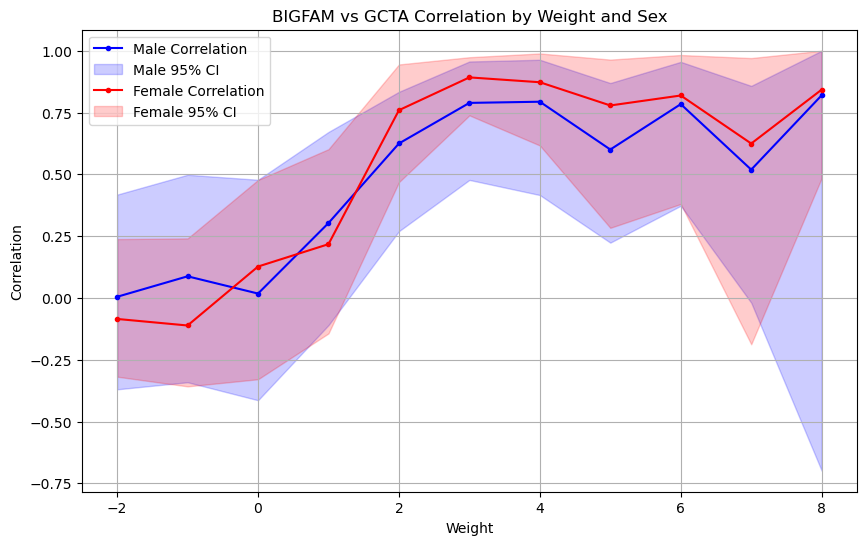

In [50]:
# 결과 출력
print("Correlations between BIGFAM and GCTA by weight for males and females:")
print(result_df)

# 시각화
plt.figure(figsize=(10, 6))

# Male correlation plot
plt.plot(result_df['weight'], result_df['correlation_male'], 'b.-', label='Male Correlation')
plt.fill_between(result_df['weight'],
                 result_df['ci_lower_male'],
                 result_df['ci_upper_male'],
                 alpha=0.2,
                 color='blue',
                 label='Male 95% CI')

# Female correlation plot 
plt.plot(result_df['weight'], result_df['correlation_female'], 'r.-', label='Female Correlation')
plt.fill_between(result_df['weight'],
                 result_df['ci_lower_female'], 
                 result_df['ci_upper_female'],
                 alpha=0.2,
                 color='red', 
                 label='Female 95% CI')

plt.xlabel('Weight')
plt.ylabel('Correlation')
plt.title('BIGFAM vs GCTA Correlation by Weight and Sex')
plt.grid(True)
plt.legend()
plt.show()

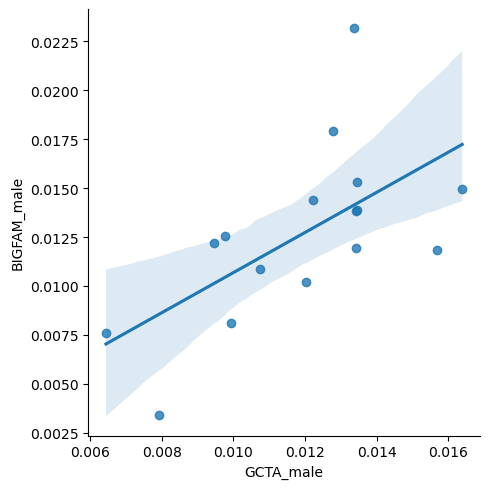

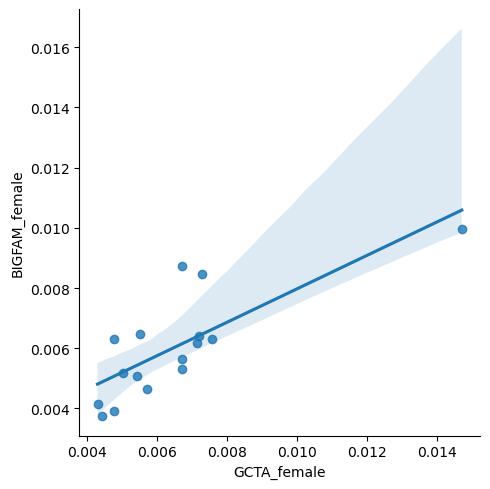

In [15]:
sns.lmplot(
    data = df_mrg_xmxf[df_mrg_xmxf["weight"] == 2],
    x = "GCTA_male",
    y = "BIGFAM_male",
    ci = 95,
    n_boot = 1000,
    scatter = True
)

sns.lmplot(
    data = df_mrg_xmxf[df_mrg_xmxf["weight"] == 2],
    x = "GCTA_female",
    y = "BIGFAM_female",
    ci = 95,
    n_boot = 1000,
    scatter = True
)

In [14]:
tt = df_mrg_xmxf[df_mrg_xmxf["weight"] == 2]
# (tt["BIGFAM_male"] / tt["GCTA_male"],
# tt["BIGFAM_female"] / tt["GCTA_female"])
tt["DCR_BIGFAM"] = tt["BIGFAM_male"] / tt["BIGFAM_female"]
tt["DCR_GCTA"] = tt["GCTA_male"] / tt["GCTA_female"]
tt[["DCR_BIGFAM", "DCR_GCTA"]].mean()

/tmp/ipykernel_272326/1770022513.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tt["DCR_BIGFAM"] = tt["BIGFAM_male"] / tt["BIGFAM_female"]
/tmp/ipykernel_272326/1770022513.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tt["DCR_GCTA"] = tt["GCTA_male"] / tt["GCTA_female"]


DCR_BIGFAM    2.092742
DCR_GCTA      1.909629
dtype: float64

In [63]:
tt.to_csv(
    "/data/jerrylee/pjt/BIGFAM.v.2.0/data/supple/UKB.XmXf.bigfam-gcta.weight2tsv",
    sep = '\t',
    index = False
)